In [1]:
%matplotlib inline
import os
import skimage
from skimage.transform import rescale, resize
import matplotlib
import matplotlib.pyplot as plt
import ntpath
import numpy as np

In [22]:
# Global Variables
DATASET_DIRNAME = "Phos2_0_2MP"
RESCALING_FACTOR = 1. / 5.
OVEREXPOSED_KEYWORDS = ["_plus_"]
UNDEREXPOSED_KEYWORDS = ["_minus_"]
REGULAR_KEYWORDS = ["_uni_", "_0"]
NONUNI_KEYWORDS = ["_nonuni_"]

In [10]:
# returns a list of subdirectories under a specific directory
def get_subdirectories(dir_name):
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, subdir_name) for subdir_name in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, subdir_name))]
    else:
        return []

In [11]:
# returns a list of all image files ending with '.png' in that specific directory
def get_files_within_dir(dir_name):
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, file_name) for file_name in os.listdir(dir_name) if file_name.endswith('.png')]
    else:
        return []

In [12]:
# gets a list of images' filenames, rescaling factor, and either the images will be RGB or grayscale
# returns a pair (image's np.ndarray either RGB or grayscale, filename)
def read_images_from_files(filenames, rescale_factor, rgb=True, flatten=False):
    # get a single image's filename to read it
    # returns the rescaled image
    def read_image_from_file(filename):
        img = skimage.io.imread(filename)
        img = rescale(img, rescale_factor, anti_aliasing=True)
        if (flatten==True):
            img = img.flatten()
        if (rgb == True):
            return img
        else:
            return skimage.color.rgb2gray(img)
        
    return [(read_image_from_file(filename), filename) for filename in filenames]

In [13]:
# get dataset directory name, rescaling factor to be applied for all the images and whether the dataset will be RGB or grayscale
# return a list of all images found along with each image filename
def get_all_images(dataset_dirname, rescale_factor, RGB=True):
    subdirectories = get_subdirectories(dataset_dirname)
    all_images = []
    for subdir in subdirectories:
        images_filenames = get_files_within_dir(subdir)
        subdir_images = read_images_from_files(filenames=images_filenames, rescale_factor=rescale_factor, rgb=RGB)
        all_images += subdir_images
    return all_images

In [14]:
def get_images_by_keywords(all_images, keywords):
    
    def keywords_found(filename):
        found = True
        image_filename = ntpath.basename(filename)
        for keyword in keywords:
            found = (found and (keyword in image_filename))
        return found
    
    return [image[0] for image in all_images if keywords_found(image[1]) == True]

In [15]:
images_data = get_all_images(DATASET_DIRNAME, RESCALING_FACTOR, RGB=False)

In [23]:
# defining the over-exposed images and labels
overexp_images = get_images_by_keywords(images_data, OVEREXPOSED_KEYWORDS)
overexp_labels = np.zeros(len(overexp_images)).tolist()
# defining the under-exposed images and labels
underexp_images = get_images_by_keywords(images_data, UNDEREXPOSED_KEYWORDS)
underexp_labels = np.ones(len(underexp_images)).tolist()
# defining the regular images and labels
reg_images = get_images_by_keywords(images_data, REGULAR_KEYWORDS)
reg_labels = np.full(len(reg_images), 2).tolist()
# defining the non-uniform images and labels
nonuni_images = get_images_by_keywords(images_data, NONUNI_KEYWORDS)
nonuni_labels = np.full(len(nonuni_images), 2).tolist()

In [24]:
print("Number of examples in over-exposed illumination pictures is: " + str(len(overexp_images)))
print("Number of examples in under-exposed illumination pictures is: " + str(len(underexp_images)))
print("Number of examples in non-uniform illumination pictures is: " + str(len(nonuni_images)))
print("Number of examples in regular illumination pictures is: " + str(len(reg_images)))

Number of examples in over-exposed illumination pictures is: 60
Number of examples in under-exposed illumination pictures is: 60
Number of examples in non-uniform illumination pictures is: 90
Number of examples in regular illumination pictures is: 15


In [25]:
def plot_image(image, title=None):
    plt.title(title)
    plt.imshow(image,
               cmap = matplotlib.cm.binary,
               interpolation="nearest")

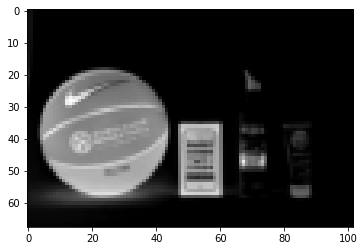

In [27]:
# plotting a random image from the images with over-exposed illumination
plot_image(overexp_images[np.random.randint(low=0, high=len(overexp_images)-1)])

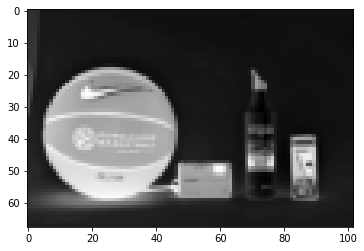

In [28]:
# plotting a random image from the images with under-exposed illumination
plot_image(underexp_images[np.random.randint(low=0, high=len(underexp_images)-1)])

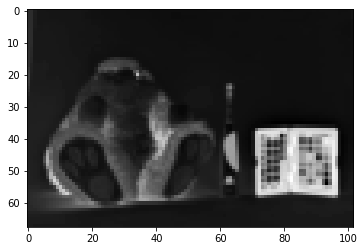

In [29]:
# plotting a random image from the images with regular illumination
plot_image(reg_images[np.random.randint(low=0, high=len(reg_images)-1)])

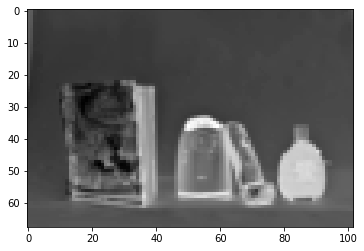

In [30]:
# plotting a random image from the images with non-uniform illumination
plot_image(nonuni_images[np.random.randint(low=0, high=len(nonuni_images)-1)])

In [31]:
X = np.asarray(overexp_images + underexp_images + reg_images + nonuni_images)
y = np.asarray(overexp_labels + underexp_labels + reg_labels + nonuni_labels)

(68, 102)


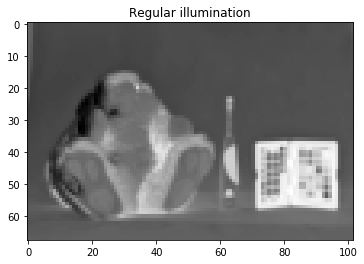

In [60]:
# plotting a random image from the whole dataset and stating its label
random_idx = np.random.randint(low=0, high=len(X)-1)
random_image = X[random_idx]
print(random_image.shape)
if (y[random_idx] == 0):
    image_title = "Over-exposed illumination"
elif (y[random_idx] == 1):
    image_title = "Under-exposed illumination"
else:
    image_title = "Regular illumination"
plot_image(random_image, title=image_title)

In [61]:
def flatten_images(images):
    return [image.flatten() for image in images]

In [62]:
def shuffle_data(X, y):
    if (len(X) != len(y)):
        return None
    p = np.random.permutation(len(X))
    return X[p], y[p]

In [63]:
flattened_X = np.asarray(flatten_images(X))
print("Shape of X matrix after flatteining all the images is: " + str(flattened_X.shape))

Shape of X matrix after flatteining all the images is: (225, 6936)


In [64]:
shuffled_X, shuffled_y = shuffle_data(flattened_X, y)

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_y, test_size=0.2, random_state=42)

In [68]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=30, random_state=42))
ovo_clf.fit(X_train, y_train)

c:\users\administrator\anaconda3\envs\ottawa\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=30,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = ovo_clf.predict(X_train)
print('Classifier scores on training set: ')
print('Accuracy is {0} '.format(accuracy_score(y_train, y_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_train, y_pred)))

Classifier scores on training set: 
Accuracy is 0.8388888888888889 
And the confusion matrix: 
 [[39  0  8]
 [ 0 30 19]
 [ 2  0 82]]


In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = ovo_clf.predict(X_test)
print('Classifier scores on training set: ')
print('Accuracy is {0} '.format(accuracy_score(y_test, y_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_test, y_pred)))

Classifier scores on training set: 
Accuracy is 0.7333333333333333 
And the confusion matrix: 
 [[ 9  0  4]
 [ 0  5  6]
 [ 2  0 19]]
